In [82]:
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan
import matplotlib as mpl
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

numpyro.enable_x64()    

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)



## Data
### Inflation rate (1947:Q1 - 2024:Q4)
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### Inflation Expectation (1982Q1-2024)
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)

### Markup (1947:Q1 - 2017:Q4)
The Cyclical Behavior of the Price-Cost Markup

Christopher J. Nekarda (Board of Governors of the Federal Reserve System)

Valerie A. Ramey (University of California, San Diego and NBER)

paper: https://econweb.ucsd.edu/~vramey/research/markupcyc.pdf

data: https://econweb.ucsd.edu/~vramey/research.html

### The number of Firm  (inverse of HHI)
HHI World Integrated Trade Solution (WITS) of the World Bank

(https://wits.worldbank.org/CountryProfile/en/country/by-country/startyear/ltst/endyear/ltst/indicator/HH-MKT-CNCNTRTN-NDX#)

quarterly HHI data obtained by linear interpolation of the original annual series

In [83]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])


# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = np.log(1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)


data_N_hat_annual = pd.read_csv("data/BN_filter_user_inputted_series_results_HHI.csv")
data_N_hat_annual["year"] = (
    pd.to_datetime(data_N_hat_annual["date"])   # ①
      .dt.year                                  # ②
)
data_N_hat_annual['DATE'] = pd.to_datetime(data_N_hat_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_hat_annual = data_N_hat_annual.set_index('DATE')
data_N_hat = data_N_hat_annual.resample('QS').asfreq()
data_N_hat = data_N_hat.reset_index()
data_N_hat['N_hat_BN'] = data_N_hat['cycle'].interpolate(method='linear')
data_N_hat["original_series"] = data_N_hat['original_series'].interpolate(method='linear')
data_N_hat["N_trend_BN"] = data_N_hat['trend'].interpolate(method='linear')
data_N_hat = data_N_hat[["DATE", "N_hat_BN", "N_trend_BN"]]

# # data_N
# data_Nb = pd.read_csv("data/BDSTIMESERIES.BDSGEO-2025-02-26T120133.csv")
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]]
# data_Nb['year'] = pd.to_datetime(data_Nb['Year (time)'], format='%Y') + pd.offsets.YearBegin(0)
# data_Nb = data_Nb.set_index('year')
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]].copy()
# data_Nb["N"] = pd.to_numeric(data_Nb["Number of firms (FIRM)"].str.replace(",", ""), errors="coerce")
# data_Nb = data_Nb.resample('QS').asfreq()
# data_Nb['Nb'] = np.log(data_Nb['N'].interpolate(method='linear'))
# data_Nb = data_Nb.reset_index()
# data_Nb['DATE'] = pd.to_datetime(data_Nb['year'])
# data_Nb = data_Nb[["DATE", "Nb"]]

data_Nb = pd.read_csv("data/BLS-bd-BDS0000000000000000120007LQ5.csv")
data_Nb["N_end"] = data_Nb["National – Establishment Births – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120007LQ5)"]
data_Nb["Nb"] = data_Nb["N_end"] * 1000
data_Nb['q'] = data_Nb["period"]
data_Nb["q"] = data_Nb["q"].str.replace(" ", "")
data_Nb["DATE"] = data_Nb["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nb = data_Nb[["DATE", "Nb"]]
data_Nd = pd.read_csv("data/BLS-bd-BDS0000000000000000120008LQ5.csv")
data_Nd["N_end"] = data_Nd["National – Establishment Deaths – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120008LQ5)"]
data_Nd["Nd"] = data_Nd["N_end"] * 1000
data_Nd['q'] = data_Nd["period"]
data_Nd["q"] = data_Nd["q"].str.replace(" ", "")
data_Nd["DATE"] = data_Nd["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nd = data_Nd[["DATE", "Nd"]]
data_Nb = pd.merge(data_Nb, data_Nd, on = "DATE")
data_Nb = data_Nb.dropna()
data_Nb["Nchange"] = data_Nb["Nb"] - data_Nb["Nd"]
data_Nb = data_Nb[data_Nb["DATE"] >= "1993-04-01"]
initial_value = 5387024
data_Nb["Nb"] = initial_value + data_Nb["Nchange"].shift(fill_value=0).cumsum()
data_Nb["Nb"] = np.log(data_Nb["Nb"])
data_Nb = data_Nb[["DATE", "Nb"]]

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_Nb, on="DATE", how="outer")
data = pd.merge(data, data_N_hat, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data = data.dropna()


# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
# Nb = jnp.array(data['Nb'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)
x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_output_gap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev = jnp.array(data['output_gap_prev'],dtype=jnp.float64)
x_markup_prev = jnp.array(1/data['markup_prev'],dtype=jnp.float64)

x = x_markup
x_prev = x_markup_prev
# N_hat = jnp.array(data["N_hat"], dtype=jnp.float64)


# NKPC under HSA

Rotemberg

$$
\hat{\pi}_{t}=\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\pi}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\zeta\left(z\right)-1}{\chi}}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)-\overset{\text{dynamic effect}}{\overbrace{\frac{1}{\chi}\frac{1-\rho\left(z\right)}{\rho\left(z\right)}\hat{N}_{t}}}
$$


Calvo
$$
\hat{\tilde{\pi}}_{t}	=	\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\tilde{\pi}}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\left(1-\phi\right)\left[1-\phi\beta\left(1-\delta\right)\right]}{\phi}\rho\left(\tilde{z}\right)}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{\tilde{p}}_{t}\right)
		-\overset{\text{dynamic effect}}{\overbrace{\frac{\left(1-\phi\right)\left[1-\phi\beta\left(1-\delta\right)\right]}{\phi}\left(1-\rho\left(\tilde{z}\right)\right)\hat{N}_{t}}}.
$$
Note that $s\left(z_{t}\right)=\frac{1}{N_{t}}$ and $Y_{t}=\frac{1}{\mu_{t}}=\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)$

Estimation strategy

$N_{t}$ denotes the measure of the number of firms (varieties), or the inverse of concentration, and $x_{t}$ denotes the measure of the output gap or the inverse of the markup.


---
---
# Estimation strategies (3 patterns)
### NKPC under CES
$s(z_t) = \gamma_{CES}(z_t)^{1−\theta}$

$\theta$ denotes the constant price elasticity, and $\zeta(z) = \theta$ and $\rho(z) = 1$:
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\theta-1}{\chi}}}x_{t}+v_{t}
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\theta$, $\chi$ and $\sigma_{v}$.

$\chi$: scales the size of the cost

$\theta$: the constant price elasticity,


### NKPC under HSA (Rotemberg)
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{\rho(z)-1}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\psi$,  $\sigma_{v}$, $\sigma_{\epsilon}$, and $\sigma_{\eta}$.

$\zeta(z) = 1-\frac{s′(z)z}{s(z)}$ : the price elasticity function $\zeta(z) > 1$

$\rho(z)=[1-\frac{dln(\frac{\zeta(z)}{\zeta(z)-1})}{dln(z)}]^{-1}$   : the pass-through rate function, $1 >\rho(z) > 0$

### Shift in the slope
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{\rho(z)-1}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$
\kappa_{t}= \psi \frac{1}{\bar{N_{t}}}
$$

$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\psi$,  $\sigma_{v}$, $\sigma_{u}$, $\sigma_{\epsilon}$, $\sigma_{\eta}$.


## Restrictions on the estimation strategies
$0<\alpha<1$,

$0<\kappa$,  

$0<\theta$

$0<\psi$ 

$\rho_1$ and $\rho_2$ must satisfy 

$\rho_2 - \rho_1 < 1$

$\rho_2 + \rho_1 < 1$

$|\rho_2| < 1$

To satisfy $\rho$ restrictions, we first sample the damping factor ($-1<r<1$) and frequency of the cycle($0<p<1$) and then calculate $\rho_1 = 2rcos(\pi p)$ and $\rho_2 = -r^2$.

In [84]:
def set_prior_distributions():
    priors = {
        # NKPC / persistence
        "alpha"     : dist.Beta(2.0, 2.0),    
        "kappa"     : dist.Gamma(2.0, 4.0),   
        "kappa_init": dist.Gamma(2.0, 4.0),  
        # Elasticity / pass-through
        "theta"     : dist.Gamma(2.0, 4.0),   
        # AR(2) via (r, p) -> (rho1, rho2) with stationarity built in
        "p"         : dist.Beta(2, 2),          # 0<p<1; avoids piling up at edges
        "r"         : dist.Uniform(-0.2, 0.8),  # -.2<r<.8; buffer from boundaries
        # Trend in \bar N_t
        "n"         : dist.Gamma(2.0, 4.0),   
        # Pass-through shift/slope param (positive)
        "psi"       : dist.Gamma(2.0, 4.0),   
        # Shock std devs (all >0)
        "sigma_v"   : dist.LogNormal(-1.0, 0.5),
        "sigma_u"   : dist.LogNormal(-1.0, 0.5),
        "sigma_eps" : dist.LogNormal(-1.0, 0.5),
        "sigma_eta" : dist.LogNormal(-1.0, 0.5),
        "sigma_e"   : dist.LogNormal(-1.0, 0.5),    
    }
    return priors

In [85]:
warmup= 25000
samples=75000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

In [86]:
# NKPC under CES
def model_0(pi, pi_prev, pi_expect, x):
    # params
    priors = set_prior_distributions()
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # NKPC
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs_t", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

print("NKPC under CES")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup)
idata_0_m = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m.sample_stats["diverging"].values   
ratio_div  = diverging.mean()                             
print(f"divergence ratio = {ratio_div:.4%}")    

NKPC under CES


sample: 100%|██████████| 100000/100000 [00:11<00:00, 8370.79it/s, 31 steps of size 1.56e-01. acc. prob=1.00]


divergence ratio = 0.0000%


In [87]:
# NKPC under HSA
def model_1(pi, pi_prev, pi_expect, x, N, l):
    # params
    priors = set_prior_distributions()
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    r = numpyro.sample("r", priors["r"])  
    p = numpyro.sample("p", priors["p"]) 
    n = numpyro.sample("n", priors["n"])
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])      
    # AR2 coefficients
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    # initial 
    bar_N_1  = numpyro.sample("bar_N_1", dist.Normal(N[0], 1))  # Nbar init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    hat_N_2  = numpyro.sample("hat_N_2", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # cycle / trend 
        # Nhat_t = numpyro.sample("Nhat_t", dist.Normal(rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2, sigma_eps))
        # Nbar_t  = numpyro.sample("Nbar_t", dist.Normal(n + Nbar_prev, sigma_eta))
        # # N (Nbar + Nhat = observed N)
        # numpyro.sample(f"N_obs_t", dist.Normal(Nhat_t + Nhat_t, sigma_u),obs=N[t])
        # If we want to remove sigma_u, then replace the above line with:
        Nbar_t  = numpyro.sample("Nbar_t", dist.Normal(n + Nbar_prev, sigma_eta))
        Nhat_obs = N[t] - Nbar_t
        Nhat = numpyro.sample("Nhat", dist.Normal(rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2, sigma_u), obs=Nhat_obs)
        numpyro.deterministic("Nhat_t", Nhat) 
        # NKPC
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat
        numpyro.sample(f"pi_obs_t", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat, Nhat_prev_1 , t], None
    scan(transition, [bar_N_1, hat_N_1, hat_N_2, t], timesteps)

# RUN MCMC
print("NKPC under HSA")
# model 1
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
idata_1_m = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar_t"]
N_bar_mean_1_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_m = N_bar_mean_1_m - 1.97 * N_bar_std_1_m
N_bar_upper_1_m = N_bar_mean_1_m + 1.97 * N_bar_std_1_m
N_hat_samples = posterior_samples["Nhat_t"]
N_hat_mean_1_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_m = N_hat_mean_1_m - 1.97 * N_hat_std_1_m
N_hat_upper_1_m = N_hat_mean_1_m + 1.97 * N_hat_std_1_m

diverging  = idata_1_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")


NKPC under HSA


sample: 100%|██████████| 100000/100000 [04:28<00:00, 372.61it/s, 255 steps of size 2.28e-02. acc. prob=0.94]


divergence ratio = 0.0000%


In [88]:
# NKPC under HSA / shift in the slope
def model_2(pi, pi_prev, pi_expect, x, N, l):
    # params
    priors = set_prior_distributions()
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    r = numpyro.sample("r", priors["r"])  
    p = numpyro.sample("p", priors["p"]) 
    n = numpyro.sample("n", priors["n"])
    psi = numpyro.sample("psi", priors["psi"])
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])      
    # AR2 coefficients
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    # initial 
    bar_N_1  = numpyro.sample("bar_N_1", dist.Normal(N[0], 1))  # Nbar init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    hat_N_2  = numpyro.sample("hat_N_2", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # cycle / trend 
        # Nhat_t = numpyro.sample("Nhat_t", dist.Normal(rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2, sigma_eps))
        # Nbar_t  = numpyro.sample("Nbar_t", dist.Normal(n + Nbar_prev, sigma_eta))
        # # N (Nbar + Nhat = observed N)
        # numpyro.sample(f"N_obs_t", dist.Normal(Nhat_t + Nhat_t, sigma_u),obs=N[t])
        # If we want to remove sigma_u, then replace the above line with:
        Nbar_t  = numpyro.sample("Nbar_t", dist.Normal(n + Nbar_prev, sigma_eta))
        Nhat_obs = N[t] - Nbar_t
        Nhat = numpyro.sample("Nhat", dist.Normal(rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2, sigma_u), obs=Nhat_obs)
        numpyro.deterministic("Nhat_t", Nhat) 
        # NKPC
        # kappa_t = numpyro.sample("kappa_t", dist.Normal(psi*(1/Nbar_t), sigma_e))
        # if we want to remove sigma_e, then replace the above line with:
        kappa_t = numpyro.deterministic("kappa_t", psi*(1/Nbar_t))
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat
        numpyro.sample(f"pi_obs_t", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat, Nhat_prev_1 , t], None
    scan(transition, [bar_N_1, hat_N_1, hat_N_2, t], timesteps)

print("NKPC under HSA: shift in slope")
kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
idata_2_m = az.from_numpyro(mcmc)

# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar_t"]
N_bar_mean_2_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_m = N_bar_mean_2_m - 1.97 * N_bar_std_2_m
N_bar_upper_2_m = N_bar_mean_2_m + 1.97 * N_bar_std_2_m
N_hat_samples = posterior_samples["Nhat_t"]
N_hat_mean_2_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_m = N_hat_mean_2_m - 1.97 * N_hat_std_2_m
N_hat_upper_2_m = N_hat_mean_2_m + 1.97 * N_hat_std_2_m
kappa_samples = posterior_samples["kappa_t"]
kappa_mean_2_m = np.mean(kappa_samples, axis=0) 
kappa_std_2_m = np.std(kappa_samples, axis=0)  
kappa_lower_2_m = kappa_mean_2_m - 1.97 * kappa_std_2_m
kappa_upper_2_m = kappa_mean_2_m + 1.97 * kappa_std_2_m

diverging  = idata_2_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"divergence ratio = {ratio_div:.4%}")

NKPC under HSA: shift in slope


sample: 100%|██████████| 100000/100000 [11:49<00:00, 140.98it/s, 1023 steps of size 9.75e-04. acc. prob=0.98]


divergence ratio = 0.2367%


## Model Comparison

## WAIC
（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

## Leave-One-Out (LOO) cross-validation
The LOO expected log predictive density is defined as
$$
\operatorname{elpd}_{\text{loo}}
\;=\;
\sum_{i=1}^{n}
  \log p\!\bigl(y_i \,\mid\, y_{-i}\bigr).
$$

where
$$
p\!\bigl(y_i \mid y_{-i}\bigr)
\;=\;
\int
  p\!\bigl(y_i \mid \boldsymbol{\theta}\bigr)\,
  p\!\bigl(\boldsymbol{\theta} \mid y_{-i}\bigr)\,
d\boldsymbol{\theta}
$$

**Interpretation** : 

$\operatorname{elpd}_{\text{loo}}$ sums the log predictive density for each observation when that observation is left out of the estimation.  Higher values indicate better out-of-sample predictive accuracy.

**Efficient computation**:

In practice we approximate (4)–(5) using \emph{PSIS-LOO} (Pareto-smoothed importance sampling), which avoids refitting the model $n$ times.

**Complexity penalty**: 
An effective number of parameters can be defined analogously to WAIC as
  $$
    p_{\text{LOO}} \;=\; \sum_{i=1}^{n} \operatorname{Var}_{\theta}
      \!\bigl(\log p(y_i \mid \boldsymbol{\theta})\bigr),
  $$
  so that $\text{LOOIC} = -2\,(\operatorname{elpd}_{\text{loo}} - p_{\text{LOO}})$.

,model,alpha,kappa,theta,rho_1,rho_2,n,psi
0,Normal NKPC,0.124,0.077,-,-,-,-,-
1,HSA NKPC no-shift,0.124,0.085,0.451,1.586,-0.632,0.004,-
2,HSA NKPC shift,0.173,-,0.018,1.576,-0.623,0.010,0.001


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

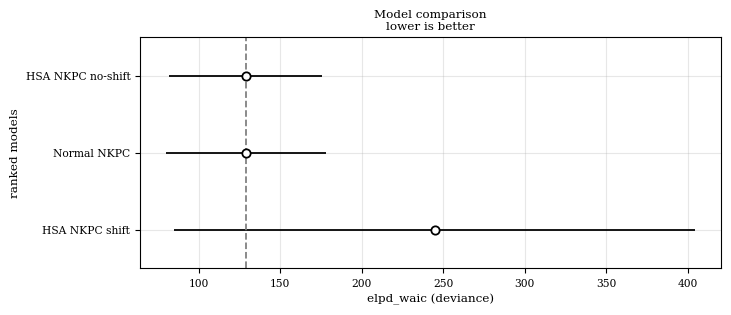

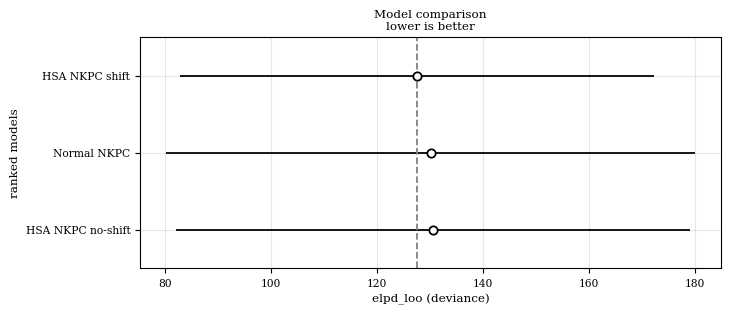

In [89]:
dict_idata = {
    'Normal NKPC':idata_0_m, 'HSA NKPC no-shift':idata_1_m, 'HSA NKPC shift':idata_2_m
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2", "n",  "psi",
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

df_waic = az.compare(dict_idata, var_name="pi_obs_t" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs_t" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))

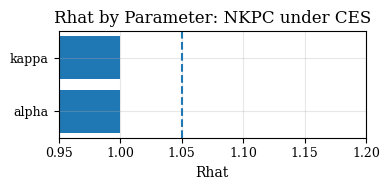

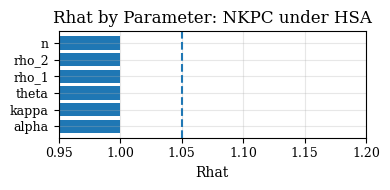

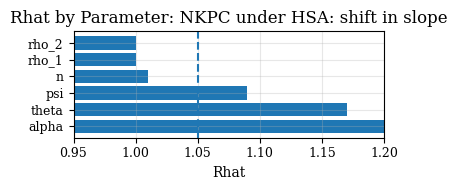

In [90]:
# az.plot_trace(idata_0_m, var_names=["alpha", "kappa"])
# az.plot_autocorr(idata0_m, var_names=["alpha", "kappa"])
summary = az.summary(idata_1_m,var_names=["alpha", "kappa"],round_to=2)
rhat = summary['r_hat'].sort_values(ascending=False)
# 3) Plot
plt.figure(figsize=(4, 2))
plt.barh(rhat.index, rhat.values)
plt.axvline(1.05, linestyle='--')        # threshold line
plt.xlabel('Rhat')                         
plt.title('Rhat by Parameter: NKPC under CES')             
plt.xlim(0.95, 1.2)
plt.tight_layout()
plt.show()

# az.plot_trace(idata_1_m, var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"])
# az.plot_autocorr(idata_1_m, var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"])
summary = az.summary(idata_1_m,var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"],round_to=2)
rhat = summary['r_hat'].sort_values(ascending=False)
# 3) Plot
plt.figure(figsize=(4, 2))
plt.barh(rhat.index, rhat.values)
plt.axvline(1.05, linestyle='--')        # threshold line
plt.xlabel('Rhat')                         
plt.title('Rhat by Parameter: NKPC under HSA')             
plt.xlim(0.95, 1.2)
plt.tight_layout()
plt.show()

# az.plot_trace(idata_2_m, var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"])
# az.plot_autocorr(idata_2_m, var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"])
summary = az.summary(idata_2_m,var_names=["alpha", "theta", "rho_1","rho_2" , "n", "psi"],round_to=2)
rhat = summary['r_hat'].sort_values(ascending=False)
# 3) Plot
plt.figure(figsize=(4, 2))
plt.barh(rhat.index, rhat.values)
plt.axvline(1.05, linestyle='--')        # threshold line
plt.xlabel('Rhat')                         
plt.title('Rhat by Parameter: NKPC under HSA: shift in slope')             
plt.xlim(0.95, 1.2)
plt.tight_layout()
plt.show()



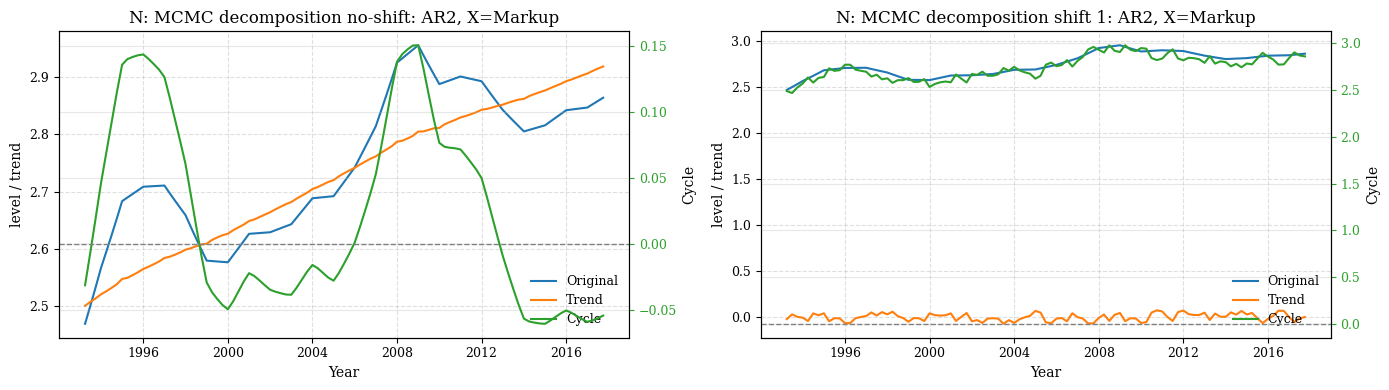

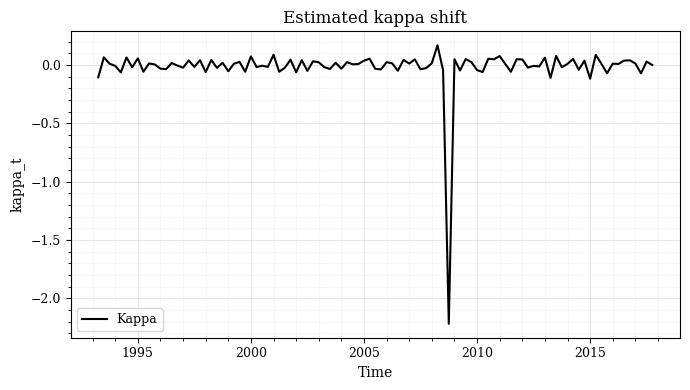

In [91]:
# --------------------------------------------------------
# Combined Figure for Model Plots
# --------------------------------------------------------
scale = 2
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data["DATE"], data["N"], N_bar_mean_1_m, N_hat_mean_1_m,
    "N: MCMC decomposition no-shift: AR2, X=Markup", loc="lower right"
)

# Second decomposition: with shift
plot_decomposition_ax(
    axes[1],
    data["DATE"], data["N"], N_bar_mean_2_m, N_hat_mean_2_m,
    "N: MCMC decomposition shift 1: AR2, X=Markup", loc="lower right"
)

plt.tight_layout()
plt.show()


scale = 2
fig, axes = plt.subplots(1, 1, figsize=(7, 4), sharex=False)
# Final layout
axes.plot(data["DATE"], kappa_mean_2_m, label="Kappa", color=colors[0])
axes.set_title("Estimated kappa shift")
axes.set_xlabel("Time")
axes.set_ylabel("kappa_t")
axes.legend()
axes.minorticks_on()
axes.grid(which='major', linestyle='-', linewidth=0.75)
axes.grid(which='minor', linestyle=':', linewidth=0.5)
axes.xaxis.set_major_locator(mdates.YearLocator(5))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()

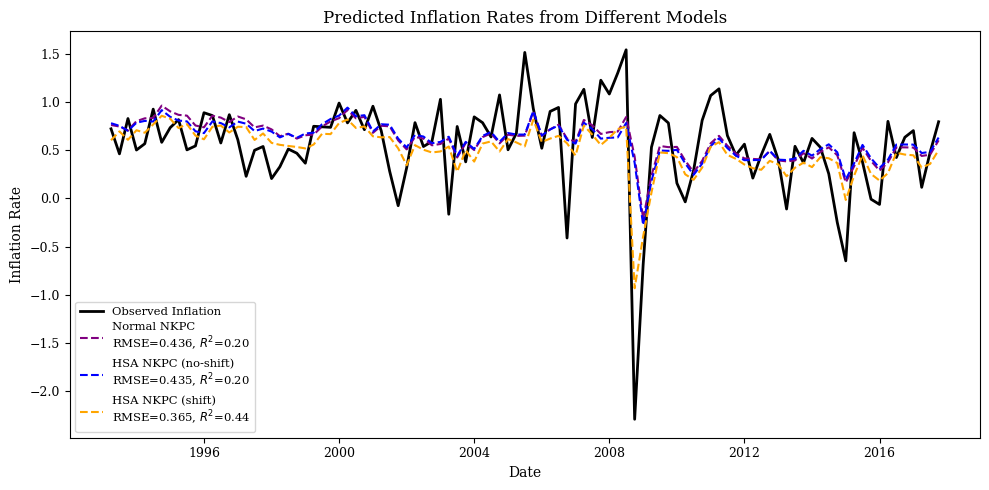

In [92]:
pi_prd_0  = idata_0_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_0_m.posterior["alpha"].mean().item()) * pi_expect + idata_0_m.posterior["kappa"].mean().item() * x_markup
pi_pred_1 = idata_1_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_1_m.posterior["alpha"].mean().item()) * pi_expect + idata_1_m.posterior["kappa"].mean().item() * x_markup - idata_1_m.posterior["theta"].mean().item() * N_hat_mean_1_m
pi_pred_2 = idata_2_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_2_m.posterior["alpha"].mean().item()) * pi_expect + kappa_mean_2_m * x_markup - idata_2_m.posterior["theta"].mean().item() * N_hat_mean_2_m

# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

# compute metrics
rmse0, r20 = rmse(pi_prd_0, pi), r2(pi_prd_0, pi)
rmse1, r21 = rmse(pi_pred_1, pi), r2(pi_pred_1, pi)
rmse2, r22 = rmse(pi_pred_2, pi), r2(pi_pred_2, pi)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data["DATE"], pi, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data["DATE"], pi_prd_0,
    label=f"Normal NKPC \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)

plt.plot(
    data["DATE"], pi_pred_1,
    label=f"HSA NKPC (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_2,
    label=f"HSA NKPC (shift)\nRMSE={rmse2:.3f}, $R^2$={r22:.2f}",
    color='orange', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()